In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

df = pd.read_csv("../data/processed/telco_customer_churn_cleaned.csv") 


In [ ]:
# Columns that always cause leakage
leakage_cols = [
    "churn_label", 
    "churn_score", 
    "cltv", 
    "churn_reason",
    "count"
]

# Columns that add no predictive value
drop_geo = [
    "country", "state", "city", "zip_code",
    "lat_long", "latitude", "longitude"
]

df_ml = df.drop(columns=leakage_cols + drop_geo)


In [ ]:
y = df_ml["churn_value"]
x = df_ml.drop(columns=["churn_value", "customerid"])

x = pd.get_dummies(x, drop_first=True)



In [ ]:
x.to_csv("../data/processed/telco_features.csv", index=False)
y.to_csv("../data/processed/telco_target.csv", index=False)



In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#1: Logistic Regression
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(x_train, y_train)

y_pred_lr = log_reg.predict(x_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


#2: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)

print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 1. Identify numeric columns
numeric_cols = ["tenure_months", "monthly_charges", "total_charges"]

# 2. Scale numeric columns using the training set only
scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

x_train_scaled[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test_scaled[numeric_cols] = scaler.transform(x_test[numeric_cols])

# 3. Retrain Logistic Regression with more iterations
log_reg_scaled = LogisticRegression(max_iter=5000)
log_reg_scaled.fit(x_train_scaled, y_train)

# 4. Predict
y_pred_scaled = log_reg_scaled.predict(x_test_scaled)

# 5. Evaluate
print("Scaled Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("Precision:", precision_score(y_test, y_pred_scaled))
print("Recall:", recall_score(y_test, y_pred_scaled))
print("F1 Score:", f1_score(y_test, y_pred_scaled))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_scaled))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_scaled))


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#1: Logistic Regression Grid Search


log_reg = LogisticRegression()

log_reg_params = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "liblinear"],
    "penalty": ["l2"],
    "max_iter": [2000, 5000]
}

log_reg_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

log_reg_grid.fit(x_train_scaled, y_train)

print("Best Logistic Regression Params:", log_reg_grid.best_params_)
print("Best Cross-Validation Accuracy:", log_reg_grid.best_score_)

# Retrain model with best params
best_log_reg = log_reg_grid.best_estimator_
y_pred_log_reg = best_log_reg.predict(x_test_scaled)

print("\nTuned Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))



#2: Random Forest Grid Search


rf = RandomForestClassifier(random_state=42)

rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced", None]
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

rf_grid.fit(x_train, y_train)  # NOTE: random forest does NOT need scaled data

print("\nBest Random Forest Params:", rf_grid.best_params_)
print("Best Cross-Validation Accuracy:", rf_grid.best_score_)

# Retrain with best params
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(x_test)

print("\nTuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



Best Random Forest Params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8103111111111111

Tuned Random Forest Performance:
Accuracy: 0.7974413646055437

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
 [[927 106]
 [179 195]]


Model Selection Summary:

After evaluating multiple models across baseline, scaled, and tuned versions, Logistic Regression was selected as the final model.

| Model                        | Accuracy   | Key Notes                                         |
| ---------------------------- | ---------- | ------------------------------------------------- |
| Baseline Logistic Regression | 0.8038     | Strong recall for minority class                  |
| Baseline Random Forest       | 0.7939     | Lower recall for minority class                   |
| Scaled Logistic Regression   | 0.8045     | Slight improvement                                |
| Tuned Logistic Regression    | **0.8088** | Highest and most stable performance               |
| Tuned Random Forest          | 0.7974     | Overfitting indicated (high CV, lower test score) |

Why Logistic Regression Was Selected

Most consistent performance across all evaluation stages.

Best test accuracy after tuning (0.8088).

Better generalisation — Random Forest showed signs of overfitting.

More interpretable and transparent (important for business insights).

Efficient and stable with lower variance across folds.

Final Model

Chosen Model: Tuned Logistic Regression

Best Parameters:

{'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}


The tuned Logistic Regression model provides the best balance of performance, interpretability, and stability, making it the most suitable choice for this project.

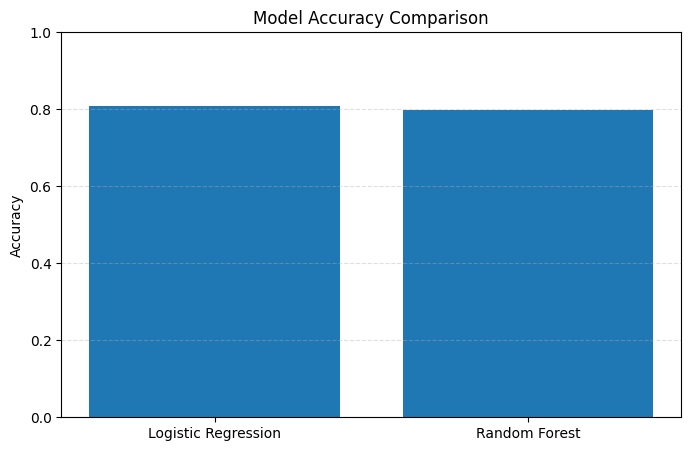

In [18]:
acc_log = best_log_reg.score(x_test_scaled, y_test)
acc_rf = best_rf.score(x_test, y_test)

models = ["Logistic Regression", "Random Forest"]
accuracies = [acc_log, acc_rf]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.savefig("../visuals/model_plots/model_accuracy_comparison.png")
plt.show()

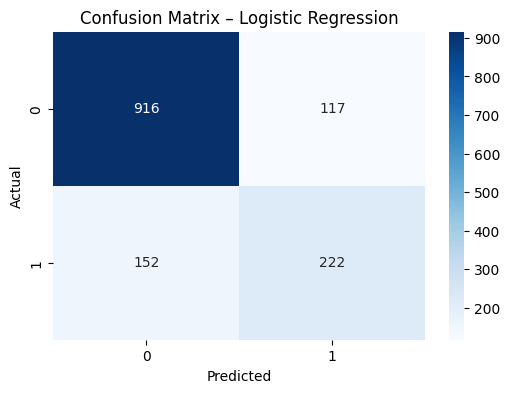

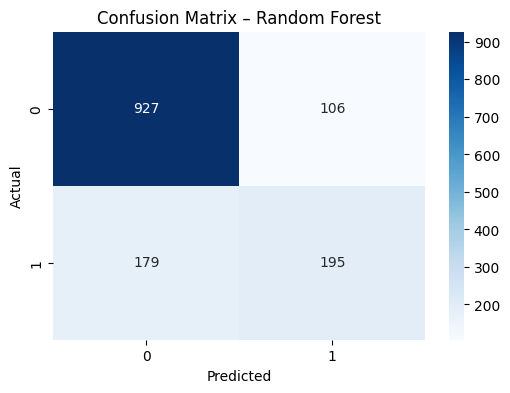

In [19]:
def plot_cm(model, x_test, y_test, title, filename):
    cm = confusion_matrix(y_test, model.predict(x_test))

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"../visuals/model_plots/{filename}", bbox_inches='tight')
    plt.show()

plot_cm(best_log_reg, x_test_scaled, y_test, "Confusion Matrix – Logistic Regression", "confusion_matrix_logreg.png")
plot_cm(best_rf, x_test, y_test, "Confusion Matrix – Random Forest", "confusion_matrix_randomforest.png")



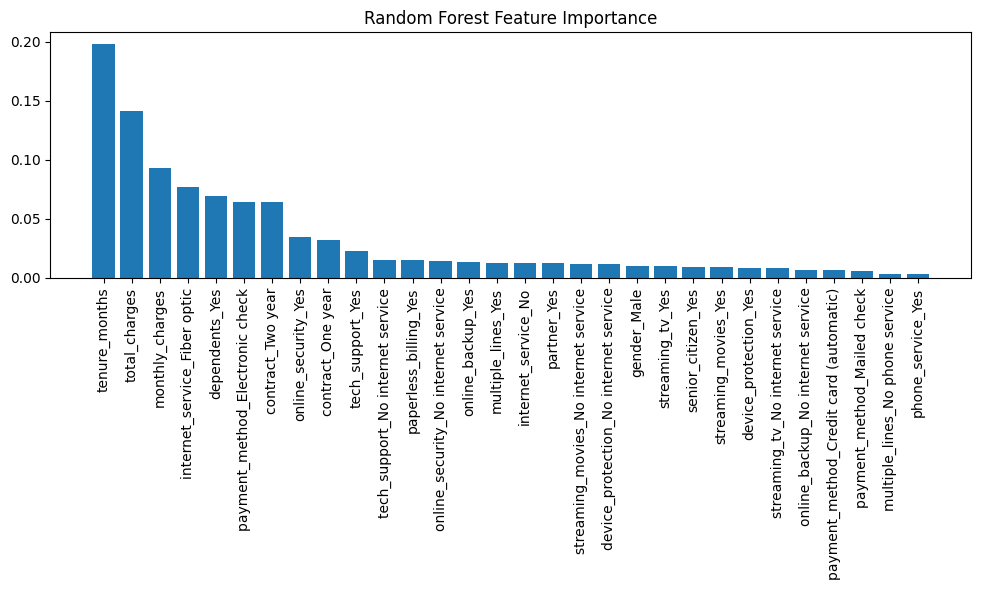

In [20]:
feature_names = x_train.columns  

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig("../visuals/model_plots/feature_importance_randomforest.png")
plt.show()